In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import math
from scipy import integrate
from tqdm.notebook import tqdm

In [140]:

class LinearGaussianSystem:
    def __init__(self, a, b, c, A, B, C, p_0, p_v, p_w):
        self.a = a
        self.b = b
        self.c = c
        self.A = A
        self.B = B
        self.C = C
        self.p_0 = p_0
        self.p_v = p_v
        self.p_w = p_w

        self.x_0 = self.p_0.rvs(size = 1)[0]
        self.pi_0 = self.p_0
        self.m0 = self.p_0.mean()
        self.D_0 = self.p_0.std()

        self.time_list = []
        self.x_list = []
        self.y_list = []
        self.est_x_list = []

        self.k_t = []
        self.a_r = []
        self.b_r = []
        self.est_x_r_list = []
        self.est_cov_r_list = []

    def __calculate__reversed_coef__(self):
        for i in range(len(self.k_t)-1):

            self.a_r.append(self.k_t[i] * self.a * self.k_t[i+1] ** (-1))
            self.b_r.append(math.sqrt(self.k_t[i] - self.k_t[i] * self.a * self.k_t[i+1]**(-1) *
                                      self.a * self.k_t[i]))


    def simulate_x(self, start = 0, end = 100, step = 1):
        prev_val = None
        curr_val = None

        for i in range(start, end + step, step):
            self.time_list.append(i)
            prev_val = curr_val
            if i == 0:
                curr_val = self.x_0
            else:
                V = self.p_v.rvs(size = 1)[0]
                curr_val = self.a * prev_val + self.c + self.b * V
            self.x_list.append(curr_val)
        return self.x_list

    def simulate_y(self):
        if len(self.x_list) == 0:
            print('WARNING: Probably You didn\'t simulate X')
            return []

        temp_var = self.A * np.array(self.x_list) + self.C + self.B * self.p_w.rvs(
             size = len(self.x_list))[0]
        self.y_list = list(temp_var)
        return self.y_list


    def estimate_x(self):
        self.est_x_list = []
        self.est_cov_list = []
        for i in tqdm(range(len(self.x_list))):
            if i == 0:
                # start
                X_hat = self.m0 + self.D_0 * self.A * (self.A * self.D_0 * self.A + self.B ** 2)**(-1) * (self.y_list[0] - self.A * self.m0 - self.C)
                self.est_x_list.append(X_hat)
                
                k0 =  self.D_0 -  self.D_0 * self.A *(self.A *  self.D_0 * self.A + self.B ** 2)**(-1) * self.A *  self.D_0
                self.est_cov_list.append(k0)
                

                self.k_t.append(self.D_0) 
            else:
                #prediction
                X_wide = self.a * self.est_x_list[i - 1] + self.c
                k_wide = self.a * self.est_cov_list[i - 1] * self.a + self.b * self.b
                
                #correction
                X_hat = X_wide + k_wide * self.A * (self.A * k_wide * self.A + self.B * self.B)**(-1) * (self.y_list[i] - self.A * X_wide - self.C)
                k = k_wide - k_wide * self.A * (self.A * k_wide * self.A + self.B * self.B)**(-1) * self.A * k_wide
                
                self.est_x_list.append(X_hat)
                self.est_cov_list.append(k)

                self.k_t.append(self.a * self.k_t[-1] * self.a + self.b * self.b)
        #Additional element 
        self.k_t.append(self.a * self.k_t[-1] * self.a + self.b * self.b)
        
        return self.est_x_list
    
    def estimate_x_r(self, K_T = None):

        if K_T is None:
            K_T = self.est_cov_list[-1]

        self.__calculate__reversed_coef__()

        self.est_x_r_list = []
        self.est_cov_r_list = []

        for i in tqdm(range(len(self.x_list))):
            if i == 0:
                # start
                X_hat = self.m0 + K_T * self.A * (self.A * K_T * self.A + self.B ** 2)**(-1) * (self.y_list[-1] - self.A * self.m0 - self.C)
                self.est_x_r_list.append(X_hat)
                
                k0 = K_T - K_T * self.A *(self.A * K_T * self.A + self.B ** 2)**(-1) * self.A * K_T
                self.est_cov_r_list.append(k0)
                
            else:
                #prediction
                a = self.a_r[i]
                b = self.b_r[i]

                X_wide = a * self.est_x_r_list[i - 1]  
                k_wide = a * self.est_cov_r_list[i - 1] * a + b * b
                
                #correction
                X_hat = X_wide + k_wide * self.A * (self.A * k_wide * self.A + self.B * self.B)**(-1) * \
                      (self.y_list[-i-1] - self.A * X_wide - self.C)
                k = k_wide - k_wide * self.A * (self.A * k_wide * self.A + self.B * self.B)**(-1) * self.A * k_wide
                
                self.est_x_r_list.append(X_hat)
                self.est_cov_r_list.append(k)


        return self.est_x_r_list
    

In [141]:
a = 1
b = 0.5
c = 0
A = 1
B = 1
C = 0
p_0 = ss.norm(loc = 0, scale = 1)
p_v = ss.norm(loc = 0, scale = 1)
p_w = ss.norm(loc = 0, scale = 1)

LGS = LinearGaussianSystem(a = a, b = b, c = c, A = A, B = B, C = C, p_0 = p_0, p_v = p_v, p_w = p_w)

x = LGS.simulate_x(end=100)
y = LGS.simulate_y()

In [142]:
%%time
x_est = LGS.estimate_x()

  0%|          | 0/101 [00:00<?, ?it/s]

CPU times: user 18.2 ms, sys: 4.12 ms, total: 22.3 ms
Wall time: 39.3 ms


In [143]:
%%time
x_r_est = LGS.estimate_x_r(LGS.est_cov_list[-1])
x_r_est.reverse()

  0%|          | 0/101 [00:00<?, ?it/s]

CPU times: user 18.1 ms, sys: 4.41 ms, total: 22.6 ms
Wall time: 33.7 ms


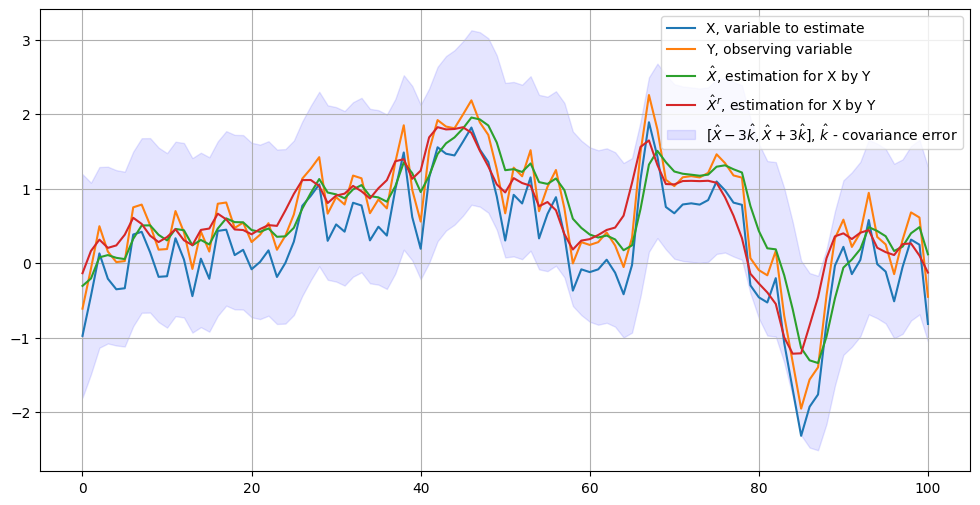

In [151]:
plt.figure(figsize=(12, 6))
plt.grid(True)

t = LGS.time_list
cov_est = LGS.est_cov_list
plt.plot(t, x, label='X, variable to estimate')
plt.plot(t, y, label='Y, observing variable')
plt.plot(t, x_est, label="$\hat{X}$, estimation for X by Y")
plt.plot(t, x_r_est, label="$\hat{X}^r$, estimation for X by Y")

plt.fill_between(t, np.array(x_est) +  3 *  np.array(cov_est),
                 np.array(x_est) -  3 * np.array(cov_est), color='blue',
                 alpha= 0.1, label='[$\hat{X} - 3 \hat{k}, \hat{X} + 3 \hat{k}$], $\hat{k}$ - covariance error' ) 

plt.legend()